# Alexander Roberts, S21158995, Big Data Coursework

**A table of contents can be shown by going to 'View' -> 'Table of Contents'**

The following code blocks assume the Cloudera Docker Compose container is active and is running normally. 

## Imports

In [1]:
# for visualisations
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# for HDFS connection
from hdfs import InsecureClient

# for HBase connection
import happybase

# for OS manipulation and system calls
import os

# for data manipulation
from pyspark.sql import SparkSession
from pyspark.sql.dataframe import DataFrame
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql import Window

# for machine learning
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer

# for type checking
from typing import Dict

# for real-world heatmap
import folium
from folium.plugins import HeatMap

## Setup - upload group 1 files (non-graph data) to HDFS

It may be necessary to create a target directory inside the HDFS. Also, the 'directory_path' may have to be adjusted to be pointed towards the folder containing the target files.

In [2]:
client = InsecureClient('http://localhost:50070', user='hadoop')

# Test connection by listing the root directory
try:
    print(client.list('/user/cloudera'))
except Exception as e:
    print(f"Connection failed: {e}")

['flamingo-data']


In [10]:
client.upload('/user/clouser', '/home/alex/Documents/BigDataAnalytics/flamingo-data', overwrite = True)

'/user/cloudera/flamingo-data'

## Setup - upload group 2 files (graph data) to HDFS

In [107]:
client = InsecureClient('http://localhost:50070', user='hadoop')

# Test connection by listing the root directory
try:
    print(client.list('/user/cloudera'))
except Exception as e:
    print(f"Connection failed: {e}")

['chat-data', 'flamingo-data']


In [106]:
client.upload('/user/cloudera', '/home/alex/Documents/BigDataAnalytics/chat-data', overwrite = True)

'/user/cloudera/chat-data'

## Setup - upload data to HBase

In [25]:
def upload_to_hbase(path_to_files:str) -> None:
    """
    Upload files of the Flamingo Game data to HBase.

    Parameters:
        - path_to_files (string): The absolute path to the files stored on the current device.

    Example:
    >>> upload_to_hbase('/home/alex/Documents/BigDataAnalytics/flamingo-data')
    """
    file_names = os.listdir(path_to_files)

    # port 9090 is the default port for HBase Thrift server
    conn = happybase.Connection('localhost', port = 9090, timeout = 100000)
    
    for file in file_names:
        path = path_to_files + '/' + file
        file_name = file.replace('.csv', '')
        df = pd.read_csv(path)

        # check if the column family already exists
        if file_name.encode() in conn.tables():
            continue

        # record how many columns there are
        col_count = len(df.columns)

        # create a new table in HBase with the name corresponding to file_name, and an
        # equal number of column families to the number of columns of the dataframe
        conn.create_table(
            file_name,
            {f'cf{i+1}':dict() for i in range(col_count)}
        )

        table = conn.table(file_name)

        # upload the data, line-by-line
        for index, row in df.iterrows():
            data = {}
            i = 1
            for col in df.columns:
                key = 'cf' + str(i) + ':' + col
                value = str(row[col])
                data[key] = value
                i+=1
            row_key = str(index)
            table.put(row_key, data)
        print("Table {} completed, along with successful data upload.".format(file_name))

    conn.close()

In [26]:
upload_to_hbase('/home/alex/Documents/BigDataAnalytics/flamingo-data')

Table game-clicks completed, along with successful data upload.
Table users completed, along with successful data upload.
Table buy-clicks completed, along with successful data upload.
Table ad-clicks completed, along with successful data upload.
Table team completed, along with successful data upload.
Table level-events completed, along with successful data upload.
Table user-session completed, along with successful data upload.
Table team-assignments completed, along with successful data upload.


In [23]:
# delete all tables if desired

def delete_hbase_tables() -> None:
    """
    Delete all HBase tables.

    Parameter:
        - conn (happybase.connection.Connection): The pre-defined connection to the HBase Thrift Server.

    Example:
    >>> conn = conn = happybase.Connection('localhost', port = 9090, timeout = 100000)
    >>> delete_hbase_tables(conn)
    """
    conn = happybase.Connection('localhost', port = 9090, timeout = 100000)
    
    for table_name in conn.tables():
        table_str = table_name.decode('utf-8')  # Convert bytes to string
        conn.disable_table(table_str)  # Disable table before dropping
        conn.delete_table(table_str)   # Drop the table
        print(f"Dropped table: {table_str}")
    conn.close()

## Setup - download data

In [5]:
# create a Spark Session
spark = SparkSession.builder \
    .appName("BigDataAnalysis") \
    .getOrCreate()

def retrieve_hbase_data(spark: SparkSession) -> Dict[str, DataFrame]:
    """
    Retrieve the stored flamingo data from the HBase storage.

    Parameter:
        - spark (SparkSession): The current SparkSession.

    Returns:
        - Dict[str, DataFrame]: a dictionary with key values corresponding to the original file names,
                                and the respective values being Spark DataFrames.
    """
    conn = happybase.Connection('localhost', port = 9090, timeout = 100000)

    # a dictionary to store all of the files in separate dataframes
    # key : file name, value : dataframe of the file data
    df_dict = {}
    
    for table_name in conn.tables():
        table = conn.table(table_name.decode('utf-8'))

        # list temporarily holds the table data
        data_list = []
        for key, data in table.scan():
            row_dict = {'row_key': key.decode('utf-8')}
            for column, value in data.items():
                row_dict[column.decode('utf-8')] = value.decode('utf-8')
            data_list.append(row_dict)
    
        # convert the data into a Pandas dataframe temporarily
        df = pd.DataFrame(data_list)
        df = df.drop(columns=['row_key'])
    
        print(f"Data successfully downloaded for {table_name.decode('utf-8')}.")
    
        # attempt to convert columns from string (which is the default) into a numbers type or datetime
        # if both attempts fail, it will be ignored (as it should probably be a string)
        for col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                try:
                    df[col] = pd.to_datetime(df[col])
                except ValueError:
                    pass
    
        # remove some semantic wording in the column names that was necessary for HBase
        # e.g., 'cf1:timestamp' becomes 'timestamp'
        df.columns = df.columns.str.replace(r'cf\d+:', '', regex=True)
    
        # add the dataframe to the dictionary, and convert it into a Spark dataframe
        df_dict[table_name.decode('utf-8')] = spark.createDataFrame(df)

    return df_dict

In [17]:
df_dict = retrieve_hbase_data(spark)

Data successfully downloaded for ad-clicks.


/tmp/ipykernel_113619/2262595161.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])


Data successfully downloaded for buy-clicks.
Data successfully downloaded for game-clicks.
Data successfully downloaded for level-events.
Data successfully downloaded for team.


/tmp/ipykernel_113619/2262595161.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
/tmp/ipykernel_113619/2262595161.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
/tmp/ipykernel_113619/2262595161.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])


Data successfully downloaded for team-assignments.
Data successfully downloaded for user-session.


/tmp/ipykernel_113619/2262595161.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
/tmp/ipykernel_113619/2262595161.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])


Data successfully downloaded for users.


/tmp/ipykernel_113619/2262595161.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
/tmp/ipykernel_113619/2262595161.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
/tmp/ipykernel_113619/2262595161.py:47: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])


In [18]:
df_dict.keys()

dict_keys(['ad-clicks', 'buy-clicks', 'game-clicks', 'level-events', 'team', 'team-assignments', 'user-session', 'users'])

## EDA: User analysis

### Total users

The number of users on the Flamingo Game platform.

In [ ]:
df_dict['users'].distinct().count()

In [ ]:
df_dict['users'].columns

### **Data enrichment - age groups**

The user's date of birth will be compared to the current date to determine what their age would be in years. This can then be further used to group the users into age groups, which might be more averaged, but are typically easier for data manipulation and provide more generalised insights into the data.

In [ ]:
# 365 days in a year on average
df_dict['users'] = df_dict['users'].withColumn("ageInYears", floor(datediff(current_date(), col("dob")) / 365))

In [ ]:
df_dict['users'] = df_dict['users'].withColumn(
    "ageGroup",
    when(col("ageInYears") < 20, "Under 20")
    .when((col("ageInYears") >= 20) & (col("ageInYears") < 40), "20-39")
    .when((col("ageInYears") >= 40) & (col("ageInYears") < 60), "40-59")
    .when((col("ageInYears") >= 60) & (col("ageInYears") < 80), "60-79")
    .otherwise("80+")
)

In [ ]:
total_users = df_dict['users'].distinct().count()

group_counts = df_dict['users'].groupBy("ageGroup").agg(count("*").alias("count"))
group_counts = group_counts.withColumn("percentage", round((col("count") / total_users) * 100, 2))
group_counts.show()

### Age groups pie chart

In [ ]:
group_counts_pd = group_counts.toPandas()

In [ ]:
plt.figure(figsize = (6, 6))
plt.pie(group_counts_pd["percentage"], labels = group_counts_pd["ageGroup"],
        autopct = "%1.1f%%", startangle = 140, colors=["#ff9999","#66b3ff","#99ff99","#ffcc99","#c2c2f0"])
plt.title("Age Group Distribution")
plt.show()

## EDA: geographic location analysis

In [ ]:
country_counts_pd = df_dict['users'].groupBy("country").count().toPandas()

# the GitHub file will be used to convert the ISO-2 country codes to latitude, longitude coordinates
country_coords = pd.read_csv("https://gist.githubusercontent.com/tadast/8827699/raw/61b2107766d6fd51e2bd02d9f78f6be081340efc/countries_codes_and_coordinates.csv",
                            quotechar = '"', skipinitialspace = True)

# merge the two dataframes together based on the common ISO-2 code
merged_data = country_counts.merge(country_coords, left_on = "country", right_on = "Alpha-2 code", how = "inner")

# create the map object
m = folium.Map(location=[20, 0], zoom_start=2)

# add the heatmap layer
heat_data = list(zip(merged_data["Latitude (average)"], merged_data["Longitude (average)"], merged_data["count"]))
HeatMap(heat_data).add_to(m)

m.save("location-analysis.html")
m

## EDA: platform type

In [ ]:
platform_counts = df_dict['user-session'].groupBy("platformType").count()
platform_counts = platform_counts.withColumn("percentage", round((col("count") / total_count) * 100, 2))

In [ ]:
platform_counts = platform_counts.toPandas()

In [ ]:
plt.figure(figsize = (6, 6))
plt.pie(platform_counts["percentage"], labels = platform_counts["platformType"],
        autopct = "%1.1f%%", startangle = 140, colors = ["#ff9999","#66b3ff","#99ff99","#ffcc99","#c2c2f0"])
plt.title("Platform Type Distribution")
plt.show()

## EDA: Team analysis

### Top 10 teams by 'strength'

In [ ]:
strongest_teams = df_dict['team'].orderBy("strength", ascending = False) \
    .select("teamId", "name", "strength", "teamCreationTime").limit(10).toPandas()

In [ ]:
plt.figure(figsize = (10, 5))
plt.bar(strongest_teams["name"], strongest_teams["strength"], color = "skyblue")
plt.xlabel("Team Name")
plt.ylabel("Strength")
plt.title("Top 10 Teams by Strength")
plt.xticks(rotation = 45)

### Top 10 oldest teams

In [ ]:
df_dict['team'].orderBy("teamCreationTime", ascending = True) \
    .select("teamId", "name", "strength", "teamCreationTime").show(10)

In [ ]:
strongest_teams = df_dict['team'].select("strength", "teamCreationTime")
strongest_counts = strongest_teams.withColumn("teamCreation", floor(datediff(current_date(), col("teamCreationTime")))).toPandas()

In [ ]:
plt.figure(figsize = (8, 5))
plt.hist(strongest_counts["strength"], bins = 35, color = "green", edgecolor = "black", alpha = 0.7)
plt.xlabel("Strength")
plt.ylabel("Frequency")
plt.title("Distribution of Teams Strengths")
plt.grid(False)
plt.show()

## EDA: Adverts and purchases

### Minimum and maximum prices

In [ ]:
df_dict['buy-clicks'].agg(min("price").alias("minimum_price"),
                          max("price").alias("maximum_price")).show()

### Item purchase frequency

In [ ]:
df_dict['buy-clicks'].groupBy("price", "buyId").count() \
    .orderBy("count", ascending = False).show()

### Top 10 spenders

In [ ]:
top_spenders = df_dict['buy-clicks'].groupBy("userId") \
    .agg(sum("price").alias("total_spent")) \
    .orderBy(col("total_spent"), ascending = False).limit(10)

In [ ]:
top_spenders.show(10)

In [ ]:
top_users_spenders_combined = top_users.join(df_dict['users'], on = "userId", how = "inner")

In [ ]:
# converting to a Pandas DataFrame for visuaisation
top_users_spenders_combined = top_users_spenders_combined.toPandas()

In [ ]:
top_users_spenders_combined = top_users_spenders_combined.sort_values(by = "total_spent", ascending = False)

In [ ]:
def get_age_color(group):
    if group == "Under 20":
        return "red"
    elif group == "20-39":
        return "blue"
    elif group == "40-59":
        return "green"
    elif group == "60-79":
        return "orange"
    else:
        return "purple"

In [ ]:
colours = [get_age_color(age) for age in df_combined["ageGroup"]]

In [ ]:
plt.figure(figsize = (10, 5))
plt.bar(df_combined["userId"].astype(str), df_combined["total_spent"], color = colours)
plt.xlabel("User ID")
plt.ylabel("Total Spent")
plt.title("Top 10 Users by Spending")
plt.xticks(rotation = 45)  # Rotate labels for readability
age_group_colors = {
    "Under 20": "red",
    "20-39": "blue",
    "40-59": "green",
    "60-79": "orange",
    "80+": "purple"
}
legend_patches = [mpatches.Patch(color = color, label = label) for label, color in age_group_colors.items()]
plt.legend(handles = legend_patches, title = "Age Groups")
plt.show()

## Machine Learning: Clustering

### Preprocessing and optimisation

K-means clustering will be used to create clusters for determining the number of ads a user can click vs. how much money they actually spend on the ads in total.

In [37]:
# get the revenue generated by each user via aggregation and summarisation
revenue_by_user = df_dict['buy-clicks'].groupBy('userId').agg(sum(col('price')).alias("userRevenue"))

In [20]:
# the number of ads clicked by each user
num_of_ads_clicked = df_dict['ad-clicks'].groupBy('userId').count() \
    .withColumnRenamed("count", "totalAdClicks")

In [21]:
combined_revenue_ad_clicks = revenue_by_user.join(num_of_ads_clicked, on = "userId", how = "inner")

In [22]:
# remove userId as it does not add any insight to the relationship between revenue from users to the number of ads clicked
combined_revenue_ad_clicks = combined_revenue_ad_clicks.drop("userId")

In [23]:
assembler = VectorAssembler(inputCols=["userRevenue", "totalAdClicks"], outputCol="features")
# only the user revenue and the total ads clicked are required
data_vector = assembler.transform(combined_revenue_ad_clicks.select("userRevenue", "totalAdClicks"))

In [24]:
def elbow_method_kmeans(data_vector: DataFrame) -> None:
    """
    Perform the Elbow Method to determine the optimal number of clusters for KMeans. Results are displayed, and a
    graph of the WCSS scores is shown so the user can decide on the optimal k value.

    Parameters:
        - data_vector (PySpark DataFrame): a preprocessed dataframe that contains a 'features' column that will be
        used for applying KMeans.
    """
    wcss_scores = []  # stores WCSS values
    silhouette_scores = [] # store silhouette scores
    k_values = range(2, 12)  # test k values from 2 to 9
    evaluator = ClusteringEvaluator(featuresCol = "features", predictionCol = "prediction", metricName = "silhouette")
    
    for k in k_values:
        print(f"Training for cluster size {k}")
        kmeans = KMeans(featuresCol = "features", k = k, seed = 42)
        model = kmeans.fit(data_vector)
        predictions = model.transform(data_vector)
        silhouette_score = evaluator.evaluate(predictions)
        
        print("Silhouette Score:", silhouette_score)
        print("WCSS: ", model.summary.trainingCost, end = "\n-------------------------\n")
        
        wcss_scores.append(model.summary.trainingCost)  # WCSS (Within-Cluster Sum of Squares)
        silhouette_scores.append(silhouette_score)

    plt.figure(figsize=(8, 5))
    plt.plot(k_values, wcss_scores, marker = 'o', linestyle = '--')
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
    plt.title("Elbow Method for Optimal k")
    plt.show()

Training for cluster size 2


Silhouette Score: 0.815078187001984
WCSS:  397756.703195797
-------------------------
Training for cluster size 3


Silhouette Score: 0.6629119726622588
WCSS:  244528.8580592992
-------------------------
Training for cluster size 4


Silhouette Score: 0.6014203844015832
WCSS:  171986.85494596406
-------------------------
Training for cluster size 5
Silhouette Score: 0.6126506989231827
WCSS:  128572.2108400063
-------------------------
Training for cluster size 6
Silhouette Score: 0.6216081703909593
WCSS:  99386.492059552
-------------------------
Training for cluster size 7


Silhouette Score: 0.6081741959620383
WCSS:  94810.39864131666
-------------------------
Training for cluster size 8


Silhouette Score: 0.5847883176142692
WCSS:  76404.21706292809
-------------------------
Training for cluster size 9
Silhouette Score: 0.5457902548937302
WCSS:  68225.61933396819
-------------------------
Training for cluster size 10
Silhouette Score: 0.5681673874575263
WCSS:  57562.51028538294
-------------------------
Training for cluster size 11
Silhouette Score: 0.5407764336056853
WCSS:  54664.01200368661
-------------------------


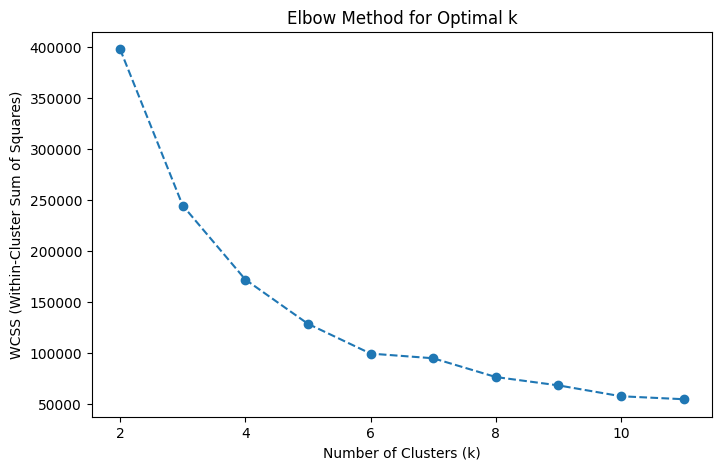

In [25]:
elbow_method_kmeans(data_vector)

The optimal k value appears to be 6, therefore, this will be used to train the final clustering model.

In [26]:
kmeans = KMeans(featuresCol = "features", k = 6, seed = 42)  # seed is used to improve reproducibility
model = kmeans.fit(data_vector)

### Evaluation

In [27]:
# get the silhouette scores
evaluator = ClusteringEvaluator(featuresCol = "features", predictionCol = "prediction", metricName = "silhouette")
predictions = model.transform(data_vector)

In [28]:
print("WCSS score for k = 6: ", model.summary.trainingCost)
print("Silhouette score for k = 6: ", evaluator.evaluate(predictions))

WCSS score for k = 6:  99386.492059552
Silhouette score for k = 6:  0.6216081703909593


Getting the cluster size distribution.

In [29]:
predictions_pd = predictions.groupBy("prediction").count().toPandas()

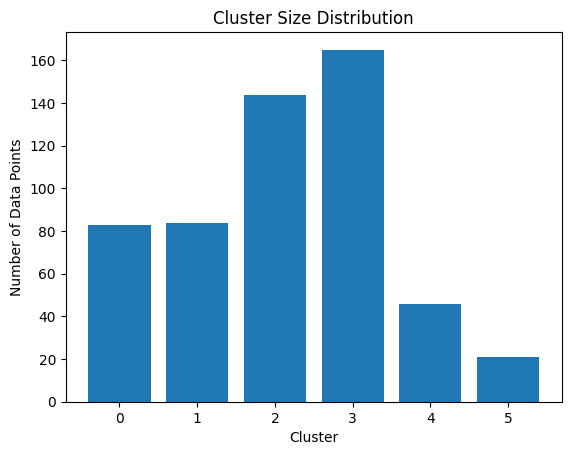

In [30]:
plt.bar(predictions_pd['prediction'], predictions_pd['count'])
plt.xlabel("Cluster")
plt.ylabel("Number of Data Points")
plt.title("Cluster Size Distribution")
plt.show()

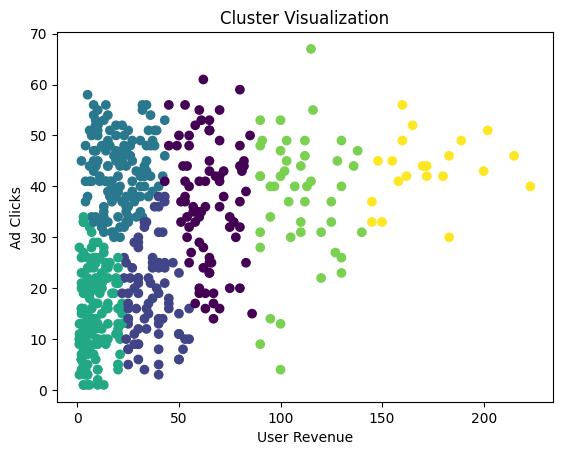

In [36]:
plt.scatter(data_vector.select("userRevenue").collect(), data_vector.select("totalAdClicks").collect(),
            c = predictions.select("prediction").collect(), cmap = "viridis")
plt.xlabel("User Revenue")
plt.ylabel("Ad Clicks")
plt.title("Cluster Visualization")
plt.show()

## Machine Learning: Classification

### Preprocessing

In [39]:
user_window = Window.partitionBy("userId").orderBy("timestamp")

# calculate sesssion duration using 'start' and 'end' labels from 'sessionType'
tmp = df_dict['user-session'].withColumn(
    "sessionDuration",
    when(
        col("sessionType") == "end",
        unix_timestamp(col("timestamp")) - 
        unix_timestamp(lag("timestamp").over(user_window))
    ).otherwise(None)
)

# retrieve the time since the user's last session
tmp = tmp.withColumn(
    "timeSinceLastSession",
    unix_timestamp(col("timestamp")) - 
    unix_timestamp(lag("timestamp").over(user_window))
)

# count how many sessions the user has had
tmp = tmp.withColumn(
    "totalSessions",
    count("*").over(Window.partitionBy("userId"))
)

# get the average amount of time between sessions for that user
tmp = tmp.withColumn(
    "avgTimeBetweenSessions",
    avg("timeSinceLastSession").over(Window.partitionBy("userId"))
)

# get the time of day, then categorise into 'morning', 'afternoon', and 'evening'
tmp = tmp.withColumn(
    "hourOfDay", 
    hour(col("timestamp"))
).withColumn(
    "timeOfDay",
    when((col("hourOfDay") >= 6) & (col("hourOfDay") < 12), "morning")
     .when((col("hourOfDay") >= 12) & (col("hourOfDay") < 18), "afternoon")
     .otherwise("evening")
)

# target variable
tmp = tmp.withColumn(
    "nextSessionTime",
    lead(unix_timestamp("timestamp")).over(user_window)
).withColumn(
    "retentionLabel",
    when(
        (col("nextSessionTime") - unix_timestamp(col("timestamp"))) <= 86400, 1  # 86400 sec = 24h
    ).otherwise(0)
)

# feature selection
feature_cols = [
    "sessionDuration",
    "timeSinceLastSession",
    "totalSessions",
    "avgTimeBetweenSessions",
    "hourOfDay",
    "retentionLabel"
]
retention_df = tmp.select(feature_cols).na.drop()

In [40]:
# remove invalid session durations (which can arise due to the use of 'Window' and overlapping times)
retention_df_clean = retention_df.filter(col("sessionDuration") > 0)

# simplying the relation between session duration and the average time between sessions for the respective user
# using a ratio (sessionIntensity)
# additionally, perform feature enrichment by converting the hour of the day into a binary variable 'isLateNight'
retention_df_features = retention_df_clean.withColumn(
    "sessionIntensity", 
    col("sessionDuration") / col("avgTimeBetweenSessions")
).withColumn(
    "isLateNight",
    when((col("hourOfDay") >= 22) | (col("hourOfDay") <= 6), 1).otherwise(0)
)

In [41]:
retention_df.show()

+---------------+-------------+----------------------+---------+--------------+-------------------+-----------+
|sessionDuration|totalSessions|avgTimeBetweenSessions|hourOfDay|retentionLabel|   sessionIntensity|isLateNight|
+---------------+-------------+----------------------+---------+--------------+-------------------+-----------+
|          88200|            8|     90257.14285714286|       22|             1| 0.9772079772079773|          1|
|         145800|            8|     90257.14285714286|       14|             1| 1.6153846153846154|          0|
|         180000|            8|     90257.14285714286|       16|             1| 1.9943019943019944|          0|
|         217800|            8|     90257.14285714286|        5|             0| 2.4131054131054133|          1|
|         145800|           14|    121185.76923076923|       15|             1|  1.203111561080731|          0|
|         180000|           14|    121185.76923076923|       17|             1| 1.4853229149144829|     

In [54]:
# using one hot encoding for hourOfDay as it can mislead the model into thinking the sequential nature
# has importance, when it does not
hour_indexer = StringIndexer(inputCol="hourOfDay", outputCol="hourIndex")
indexer_model = hour_indexer.fit(retention_df)
retention_df = indexer_model.transform(retention_df)

hour_encoder = OneHotEncoder(
    inputCols=["hourIndex"],
    outputCols=["hourVec"],
    dropLast=False
)
encoder_model = hour_encoder.fit(retention_df)
retention_df = encoder_model.transform(retention_df)

# to help resolve the several duplicate instances in 'avgTimeBetweenSessions', this can be combined with the
# session duration to form a recency ratio, creating more generalised and rich insights
retention_df = retention_df.withColumn(
    "recencyRatio", 
    col("sessionDuration") / (col("avgTimeBetweenSessions") + 1e-6)
)

In [63]:
retention_df.select('sessionIntensity', 'totalSessions', 'isLateNight', 'hourVec', 'recencyRatio').show()

+-------------------+-------------+-----------+---------------+-------------------+
|   sessionIntensity|totalSessions|isLateNight|        hourVec|       recencyRatio|
+-------------------+-------------+-----------+---------------+-------------------+
| 0.9772079772079773|            8|          1| (24,[9],[1.0])| 0.9772079771971504|
| 1.6153846153846154|            8|          0|(24,[17],[1.0])|  1.615384615366718|
| 1.9943019943019944|            8|          0|(24,[18],[1.0])| 1.9943019942798987|
| 2.4131054131054133|            8|          1|(24,[11],[1.0])| 2.4131054130786773|
|  1.203111561080731|           14|          0| (24,[4],[1.0])| 1.2031115610708034|
| 1.4853229149144829|           14|          0| (24,[3],[1.0])| 1.4853229149022262|
| 1.7972407270465243|           14|          1| (24,[0],[1.0])|  1.797240727031694|
|  2.138864997476855|           14|          1| (24,[0],[1.0])| 2.1388649974592058|
|  2.510195726205476|           14|          0| (24,[2],[1.0])| 2.5101957261

### Retention rate distribution

In [46]:
retention = retention_df.distinct().count()
retention_count = retention_df.groupBy("retentionLabel").agg(count("*").alias("count"))
retention_count = retention_count.withColumn("percentage", round((col("count") / retention) * 100, 2))
retention_count.show()

+--------------+-----+----------+
|retentionLabel|count|percentage|
+--------------+-----+----------+
|             1| 3145|     82.59|
|             0| 1106|     29.04|
+--------------+-----+----------+



In [47]:
retention_count_pd = retention_count.toPandas()

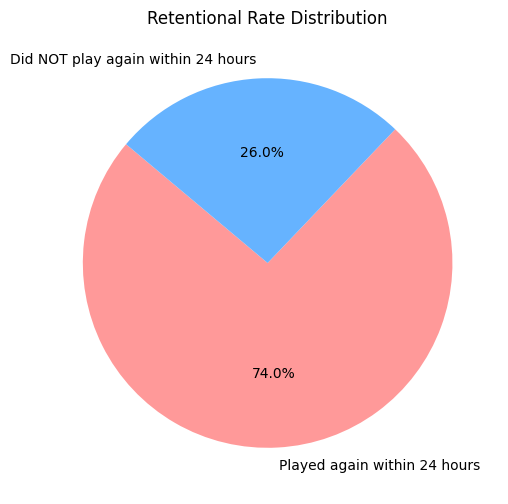

In [51]:
plt.figure(figsize = (6, 6))
plt.pie(retention_count_pd["percentage"], labels = ['Played again within 24 hours', 'Did NOT play again within 24 hours'],
        autopct = "%1.1f%%", startangle = 140, colors=["#ff9999","#66b3ff","#99ff99","#ffcc99","#c2c2f0"])
plt.title("Retentional Rate Distribution")
plt.show()

In [87]:
class_counts = retention_df.groupBy("retentionLabel").count()
majority = class_counts.filter(col('retentionLabel') == 1).first()
minority = class_counts.filter(col('retentionLabel') == 0).first()

majority_count = majority['count']
minority_count = minority['count']

In [89]:
# calculate class distribution
count_dict = {row['retentionLabel']: row['count'] for row in class_counts.collect()}

# determine sampling fractions
minority_class = [k for k, v in count_dict.items() if v == minority_count][0]
majority_class = [k for k, v in count_dict.items() if v == majority_count][0]

# calculate fraction to sample (which will be applied to the majority class)
fraction = count_dict[minority_class] / count_dict[majority_class]

fractions = {
    majority_class: fraction,  # undersample majority
    minority_class: 1.0        # keep all minority samples
}

undersampled_retention_df = retention_df.sampleBy('retentionLabel', fractions = fractions, seed = 42)

undersampled_retention_df.groupBy('retentionLabel').count().show()

+--------------+-----+
|retentionLabel|count|
+--------------+-----+
|             1| 1126|
|             0| 1106|
+--------------+-----+



In [102]:
retention = undersampled_retention_df.distinct().count()
retention_count = undersampled_retention_df.groupBy("retentionLabel").agg(count("*").alias("count"))
retention_count = retention_count.withColumn("percentage", round((col("count") / retention) * 100, 2))
retention_count.show()
undersampled_retention_count_pd = retention_count.toPandas()

+--------------+-----+----------+
|retentionLabel|count|percentage|
+--------------+-----+----------+
|             1| 1126|     54.29|
|             0| 1106|     53.33|
+--------------+-----+----------+



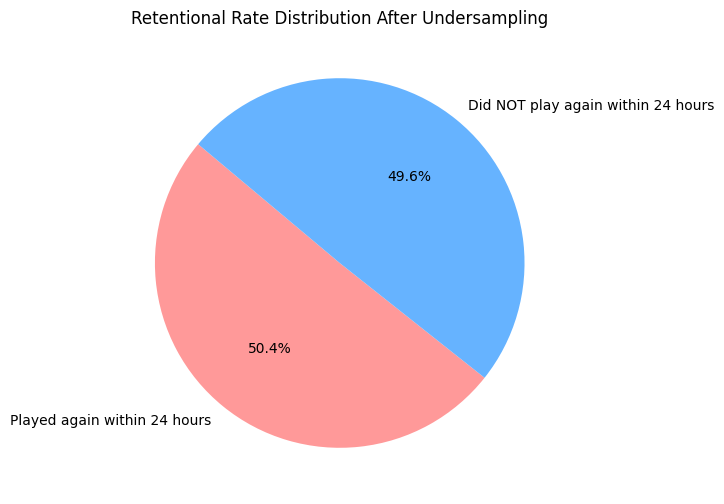

In [104]:
plt.figure(figsize = (6, 6))
plt.pie(undersampled_retention_count_pd["percentage"], labels = ['Played again within 24 hours', 'Did NOT play again within 24 hours'],
        autopct = "%1.1f%%", startangle = 140, colors=["#ff9999","#66b3ff","#99ff99","#ffcc99","#c2c2f0"])
plt.title("Retentional Rate Distribution After Undersampling")
plt.show()

### Training and evaluation

In [101]:
assembler = VectorAssembler(
    inputCols=[
        "sessionIntensity",
        "totalSessions",
        "isLateNight",
        "hourVec",
        "recencyRatio"
    ],
    outputCol="features"
)

data_vector = assembler.transform(undersampled_retention_df).select("features", "retentionLabel")

# Train-test split, 80% training, 20% testing
# seed helps make the split more reproducible
train, test = data_vector.randomSplit([0.8, 0.2], seed=42)

### Logistic Regression ###
lr = LogisticRegression(
    featuresCol="features",
    labelCol="retentionLabel",
    maxIter=10
)
lr_model = lr.fit(train)

predictions = lr_model.transform(test)
evaluator = BinaryClassificationEvaluator(
    labelCol="retentionLabel",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

tp = predictions.filter((col('prediction') == 1) & (col('retentionLabel') == 1)).count()
tn = predictions.filter((col('prediction') == 0) & (col('retentionLabel') == 0)).count()
fp = predictions.filter((col('prediction') == 1) & (col('retentionLabel') == 0)).count()
fn = predictions.filter((col('prediction') == 0) & (col('retentionLabel') == 1)).count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)
mcc = ((tp * tn) - (fp * fn)) / ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))**0.5
auc = evaluator.evaluate(predictions)

print('*' * 5, "LOGITSTIC REGRESSION", '*' * 5)
print(f"AUC: {auc:.3f}")
print(f"MCC: {mcc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1_score:.3f}", end = '\n\n')

### Random Forest ###

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="retentionLabel",
    numTrees=50
)
rf_model = rf.fit(train)
rf_predictions = rf_model.transform(test)
rf_tp = rf_predictions.filter((col('prediction') == 1) & (col('retentionLabel') == 1)).count()
rf_tn = rf_predictions.filter((col('prediction') == 0) & (col('retentionLabel') == 0)).count()
rf_fp = rf_predictions.filter((col('prediction') == 1) & (col('retentionLabel') == 0)).count()
rf_fn = rf_predictions.filter((col('prediction') == 0) & (col('retentionLabel') == 1)).count()

rf_precision = rf_tp / (rf_tp + rf_fp)
rf_recall = rf_tp / (rf_tp + rf_fn)
rf_f1_score = 2 * (rf_precision * rf_recall) / (rf_precision + rf_recall)
rf_mcc = ((rf_tp * rf_tn) - (rf_fp * rf_fn)) / ((rf_tp + rf_fp) * (rf_tp + rf_fn) * (rf_tn + rf_fp) * (rf_tn + rf_fn))**0.5
rf_auc = evaluator.evaluate(rf_predictions)

print('*' * 6, "RANDOM FOREST", '*' * 6)
print(f"AUC: {rf_auc:.3f}")
print(f"MCC: {rf_mcc:.3f}")
print(f"Precision: {rf_precision:.3f}")
print(f"Recall: {rf_recall:.3f}")
print(f"F1 Score: {rf_f1_score:.3f}")

***** LOGITSTIC REGRESSION *****
AUC: 0.958
MCC: 0.823
Precision: 0.922
Recall: 0.899
F1 Score: 0.910

***** RANDOM FOREST *****
AUC: 0.983
MCC: 0.868
Precision: 0.922
Recall: 0.949
F1 Score: 0.935
